## Set up Workspace

In [2]:
cd kddm/data/uas 

/glade/u/home/jkent/kddm/data/uas


In [3]:
ls

bilinear_129x300_257x599.nc
bilinear_49x116_97x231.nc
uas.METDATA.44i.nc@
uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.kddm-METDATA.nc@
uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc@
uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.kddm-METDATA.nc@
uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc@


### Steps

1. Read in an explore data
2. Regrid to 0.25 deg Lat-Lon grid
3. Alignepochs.R-esque function to get moving windows
4. biascorrection.R-esque function for Z-score correction of _ward wind
5. Save file
6. Compare to corrected historical and rcp85 model

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import interpolate
import xesmf as xe
import pandas as pd
from calendar import isleap

In [10]:
%matplotlib inline

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Look at Data

In [11]:
measured = xr.open_dataset('uas.METDATA.44i.nc')
hist = xr.open_dataset('uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc')
rcp85 = xr.open_dataset('uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc')

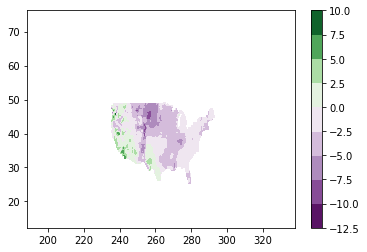

In [12]:
plt.contourf(measured.lon, measured.lat, measured.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

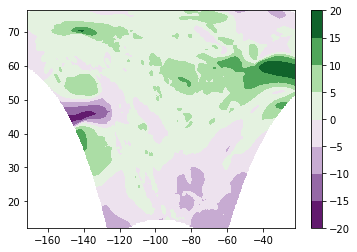

In [13]:
plt.contourf(hist.lon, hist.lat, hist.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

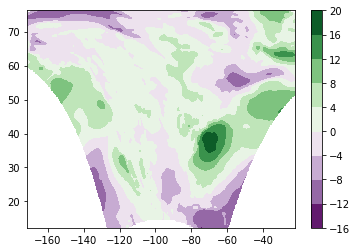

In [14]:
plt.contourf(rcp85.lon, rcp85.lat, rcp85.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

## Filter and Regrid Data to Quarter Degree Grid

In [15]:
measured_droplats = measured.dropna(dim='lat', how ='all')
measured_flt = measured_droplats.dropna(dim='lon', how='all')

In [58]:
lon_min = float(np.min(measured_flt.lon))
lon_max = float(np.max(measured_flt.lon))
lat_min = float(np.min(measured_flt.lat))
lat_max = float(np.max(measured_flt.lat))
wesn = [lon_min, lon_max, lat_min, lat_max]

In [57]:
grid = 0.25
wesn_g = [int(round(i * 4)) / 4 for i in wesn]

new_lon = np.arange(wesn_g[0],wesn_g[1], grid)
new_lat = np.arange(wesn_g[2], wesn_g[3]+grid, grid)

ds_newgrid = xr.Dataset({'lat': (['lat'], new_lat), 'lon': (['lon'], new_lon)})

In [59]:
regridder_measured = xe.Regridder(measured_flt, ds_newgrid, 'bilinear')
measured_rgrd = regridder_measured(measured_flt.uas)

Overwrite existing file: bilinear_49x116_97x231.nc 
 You can set reuse_weights=True to save computing time.


/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xesmf/smm.py:73: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


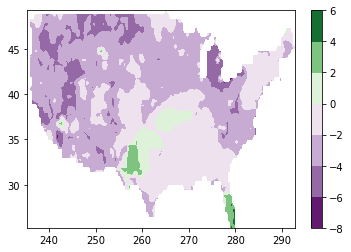

In [133]:
plt.contourf(measured_rgrd.lon, measured_rgrd.lat, measured_rgrd.isel(time=300), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [61]:
hist_poslon = hist.assign_coords(lon = hist.lon+ 360)
hist_flt = hist_poslon.sel(lon = slice(lon_min, lon_max),lat = slice(lat_min, lat_max))
regridder_hist = xe.Regridder(hist_flt, ds_newgrid, 'bilinear')
hist_rgrd = regridder_hist(hist_flt.uas)

Overwrite existing file: bilinear_49x116_97x231.nc 
 You can set reuse_weights=True to save computing time.


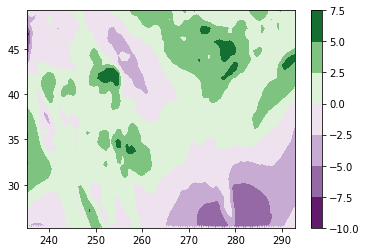

In [62]:
plt.contourf(hist_rgrd.lon, hist_rgrd.lat, hist_rgrd.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [64]:
rcp85_poslon = rcp85.assign_coords(lon = rcp85.lon+ 360)
rcp85_flt = rcp85_poslon.sel(lon = slice(lon_min, lon_max),lat = slice(lat_min, lat_max))
regridder_rcp85 = xe.Regridder(rcp85_flt, ds_newgrid, 'bilinear')
rcp85_rgrd = regridder_rcp85(rcp85_flt.uas)

Overwrite existing file: bilinear_49x116_97x231.nc 
 You can set reuse_weights=True to save computing time.


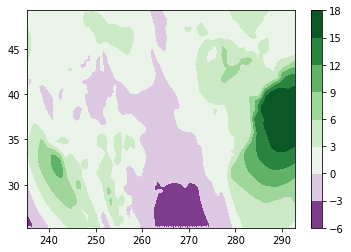

In [65]:
plt.contourf(rcp85_rgrd.lon, rcp85_rgrd.lat, rcp85_rgrd.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [22]:
#Put NaN's where there is always NaN in measured

## Align Time

In [96]:
cal_measured = measured_rgrd.time.encoding['calendar']
cal_hist = hist_rgrd.time.encoding['calendar']
cal_rcp85 = rcp85_rgrd.time.encoding['calendar']

str_dict = {'Measurement': cal_measured, 'Historical model': cal_hist, 'RCP85 model': cal_rcp85}
for k in str_dict.keys():
    print(k, ' values are on a ', format_dict[k], ' calendar')

Measurement  values are on a  gregorian  calendar
Historical model  values are on a  365_day  calendar
RCP85 model  values are on a  365_day  calendar


In [98]:
hist_dropearly = hist_rgrd.sel(time = slice('1979-01',None))
rcp85_droplate= rcp85_rgrd.sel(time = slice(None,'2013-12-31'))
rcp85_future = rcp85_rgrd.sel(time = slice('2014-01-01',None))

if (cal_hist == cal_rcp85):
    past_model = xr.concat((hist_dropearly, rcp85_droplate), dim='time')
else: #Raise Error instead?
    print('Models must be on same calendar to concatenate') 

In [101]:
years = measured_rgrd.time.dt.year
leap_bool = [isleap(y) for y in set(years.values)]
assert len(measured_rgrd.time)-len(past_model.time) == leap_bool.count(True)

In [ ]:
#Seth suggests subsampling instead of interpolating
#Interp okay for continuous variables
#Interp not good for spiky discontinuos variables (precipitation!)
#Make an align_calendars function that provides options, interpolation or subsampling randomly placed
#Print total amount of precipitation that was dropped in subsampling?

In [105]:
measured_noleap = measured_rgrd.interp(time = past_model.time)
assert len(measured_noleap.time)-len(past_model.time) == 0

## Grouby Average for Every Day Across Years
#### (Dec 15 -> full 12 months -> Jan 15)

In [1]:
#Groupby is really slow??

measured_avyear = measured_noleap.groupby('time.day').mean(dim='time')

NameError: name 'measured_noleap' is not defined

In [ ]:
model_avyear = past_model.groupby('time.day').mean(dim='time')

In [ ]:
measured_avyear

## Z-Score Bias Correction Method

In [138]:
#Moving window
mv_window_w = 31

In [139]:
measured_mean = measured_noleap.rolling(time=mv_window_w, min_periods=15, center=True).mean()
measured_std = measured_noleap.rolling(time=mv_window_w, min_periods=15, center=True).std()
measured_zscore = (measured_noleap - measured_mean) / measured_std

In [145]:
model_mean = past_model.rolling(time=mv_window_w, min_periods=15, center=True).mean()
model_std = past_model.rolling(time=mv_window_w, min_periods=15, center=True).std()
model_zscore = (past_model - model_mean) / model_std

In [ ]:
future_mean = rcp85_future.rolling(time=mv_window_w, min_periods=15, center=True).mean()
future_std = rcp85_future.rolling(time=mv_window_w, min_periods=15, center=True).std()
future_zscore = (future_model - future_mean) / future_std

In [ ]:
shift = measured_mean - model_mean
scale = measured_std - model_std

In [ ]:
new_mean_past = model_mean + shift
new_std_past = model_std * scale

new_mean = future_mean + shift
new_std = future_std * scale

In [ ]:
past_corrected = (model_zscore * new_std_past) + new_mean_past
future_corrected = (future_zscore * new_std) + new_mean

In [ ]:
#How to display this?